In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, subdirs, _ in os.walk('/kaggle/input'):
    for subdir in subdirs:
        print(os.path.join(dirname, subdir))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification
/kaggle/input/soil-classification/soil_classification-2025
/kaggle/input/soil-classification/soil_classification-2025/test
/kaggle/input/soil-classification/soil_classification-2025/train


## 1. Importing Libraries

In [3]:
# Import necessary libraries for data manipulation, visualization, and deep learning
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import timm
import time
from collections import Counter

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Defining Paths

In [6]:
# Define the base directory and paths to the train and test directories, as well as the labels and ids files
base_dir = "/kaggle/input/soil-classification/soil_classification-2025"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
train_labels_path = os.path.join(base_dir, "train_labels.csv")
test_ids_path = os.path.join(base_dir, "test_ids.csv")

In [7]:
# Verify paths
for path in [train_dir, test_dir, train_labels_path, test_ids_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path not found: {path}")

## 3. Loading Data

In [8]:
# Load the train labels from the CSV file and display initial information
train_labels_df = pd.read_csv(train_labels_path)
print("Train Labels Head:")
print(train_labels_df.head())
print(f"\nMissing values in train_labels.csv: {train_labels_df.isnull().sum().sum()}")

Train Labels Head:
           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil

Missing values in train_labels.csv: 0


In [9]:
# Get the unique class names and create a label map
classes = train_labels_df['soil_type'].unique()
label_map = {cls: idx for idx, cls in enumerate(classes)}
print(f"\nClasses: {classes}")
print(f"Label Map: {label_map}")


Classes: ['Alluvial soil' 'Clay soil' 'Red soil' 'Black Soil']
Label Map: {'Alluvial soil': 0, 'Clay soil': 1, 'Red soil': 2, 'Black Soil': 3}


In [10]:
# Count the number of images in train and test directories
train_images = [f for f in os.listdir(train_dir)]
test_images = [f for f in os.listdir(test_dir)]
print(f"Training Images: {len(train_images)}")
print(f"Testing Images: {len(test_images)}")

Training Images: 1222
Testing Images: 341


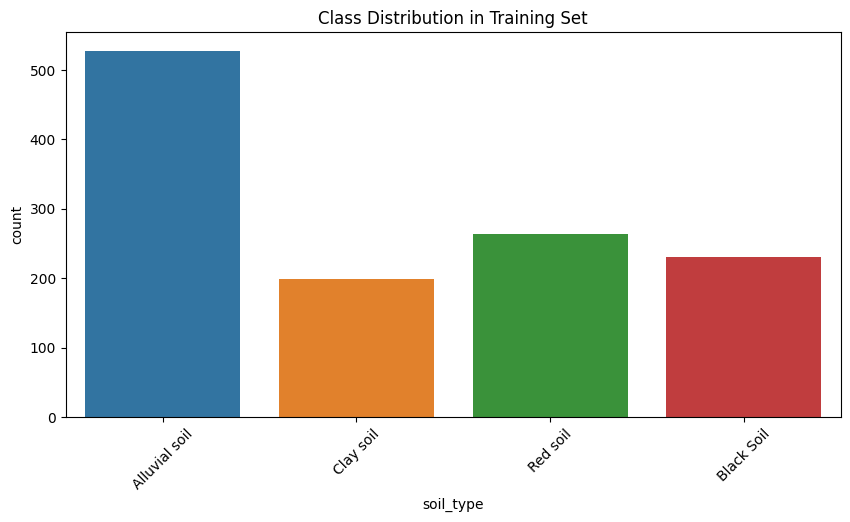

In [11]:
# Visualize the class distribution in the training set
plt.figure(figsize=(10, 5))
sns.countplot(data=train_labels_df, x='soil_type')
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

## 4. Data Preprocessing
### 4.1. Defining Transformations

In [13]:
# Define transformations for training, validation, and testing
train_transform = transforms.Compose([
    transforms.Resize((245, 245)),  # EfficientNet-B3 input size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((245, 245)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((245, 245)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 4.2. Custom Dataset Classes

In [14]:
# Custom dataset class for training and validation
class SoilDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_id = os.path.basename(img_path)
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(3, 300, 300), -1, img_id  # Dummy image for errors
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label, img_id

In [15]:
# Custom dataset for test images
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_id = os.path.basename(img_path)
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(3, 300, 300), img_id
        
        if self.transform:
            image = self.transform(image)
        return image, img_id


### 4.3. Preparing Data

In [16]:
# Prepare the data by mapping images to labels and splitting into train/validation sets
train_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)]
train_labels_map = train_labels_df.set_index('image_id')['soil_type'].to_dict()
train_labels = []
valid_images = []
for img in train_images:
    img_id = os.path.basename(img)
    if img_id in train_labels_map:
        train_labels.append(label_map[train_labels_map[img_id]])
        valid_images.append(img)
    else:
        print(f"Warning: {img_id} not in train_labels.csv")

In [17]:
# Split the data into training and validation sets
train_img, val_img, train_lbl, val_lbl = train_test_split(
    valid_images, train_labels, test_size=0.20, random_state=42, stratify=train_labels
)

In [18]:
# Create datasets
train_dataset = SoilDataset(train_img, train_lbl, train_transform)
val_dataset = SoilDataset(val_img, val_lbl, val_transform)
test_dataset = TestDataset(
    [os.path.join(test_dir, img) for img in os.listdir(test_dir)],
    test_transform
)


### 4.4. Creating Data Loaders

In [19]:
# Create data loaders for batching and shuffling
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 977
Validation dataset size: 245
Test dataset size: 341


### 4.5. Visualizing Sample Images

In [20]:
# Denormalize function for visualization
def denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.clone()
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)

In [21]:
# Visualize sample images per class
def show_samples_per_class(dataset, label_map, classes):
    fig, axes = plt.subplots(2, len(classes), figsize=(len(classes) * 3, 6))
    found = set()
    for img, label, img_id in dataset:
        if label not in found and label != -1:
            axes[0, label].imshow(img.permute(1, 2, 0).numpy())
            axes[0, label].set_title(f"Original\n{list(label_map.keys())[label]}")
            axes[0, label].axis('off')
            transformed = denormalize_image(img)
            axes[1, label].imshow(transformed.permute(1, 2, 0).numpy())
            axes[1, label].set_title(f"Transformed\n{list(label_map.keys())[label]}")
            axes[1, label].axis('off')
            found.add(label)
        if len(found) == len(classes):
            break
    plt.tight_layout()
    plt.show()

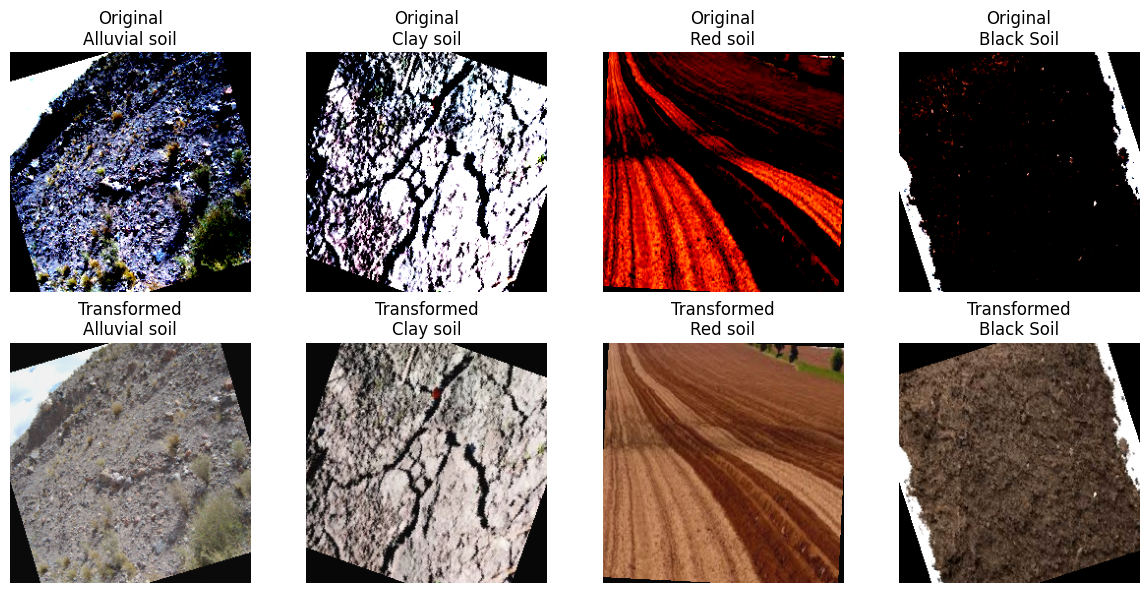

In [22]:
show_samples_per_class(train_dataset, label_map, classes)

## 5. Model Definition
### 5.1. Focal Loss

In [24]:
# Define Focal Loss to address class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

### 5.2. Initializing Models

In [ ]:
# Initialize models
models_dict = {
    "EfficientNet-B3": timm.create_model("efficientnet_b3", pretrained=True, num_classes=len(classes)),
    "ResNet-50": models.resnet50(pretrained=True)
}

# Adjust ResNet-50 classifier
models_dict["ResNet-50"].fc = nn.Linear(models_dict["ResNet-50"].fc.in_features, len(classes))

## 6. Training
### 6.1. Helper Functions

In [ ]:
# Function to compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Function to plot training and validation metrics
def plot_metrics(model_name, train_loss_list, train_acc_list, val_acc_list, val_f1_list):
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc_list, label='Train Accuracy')
    plt.plot(epochs, val_acc_list, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1_list, label='Validation F1 Score')
    plt.title(f'{model_name} - Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/{model_name.lower().replace('-', '_')}_metrics.png")
    plt.show()

### 6.2. Training Function

In [26]:
# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path):
    best_f1 = 0
    epochs_no_improve = 0
    patience = 5
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []
    val_f1_list = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        t = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels, _ in t:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            t.set_postfix(loss=loss.item(), accuracy=100 * correct_train / total_train)
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(train_acc)
        
        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_acc = 100 * correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        
        # Print epoch results
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"\nEpoch {epoch+1}:")
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%, Validation F1 Score: {val_f1:.4f}")
        print(f"Time: {epoch_mins}m {epoch_secs}s")
        
        scheduler.step(val_f1)
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with F1: {best_f1:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # if epochs_no_improve >= patience:
        #     print("Early stopping triggered.")
        #     break
        
        torch.cuda.empty_cache()
    
    return best_f1, val_acc, train_loss_list, train_acc_list, val_acc_list, val_f1_list


In [27]:
# Updated fine-tune function
def fine_tune_model(model, model_name):
    for param in model.parameters():
        param.requires_grad = False
    
    if 'efficientnet' in model_name.lower():
        for name, param in model.named_parameters():
            if 'blocks.5' in name or 'blocks.6' in name or 'head' in name or 'fc' in name:
                param.requires_grad = True
    elif 'resnet' in model_name.lower():
        for name, param in model.named_parameters():
            if 'layer4' in name or 'fc' in name:
                param.requires_grad = True
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name} - Total Parameters: {total_params:,}, Trainable Parameters: {trainable_params:,}")
    
    if trainable_params == 0:
        raise ValueError(f"No trainable parameters found for {model_name}.")

### 6.3. Training Models


Training EfficientNet-B3...
EfficientNet-B3 - Total Parameters: 10,702,380, Trainable Parameters: 8,503,006


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|██████████| 62/62 [00:10<00:00,  5.76it/s, accuracy=68.2, loss=1.71]  



Epoch 1:
Training Loss: 0.4864, Training Accuracy: 68.17%
Validation Accuracy: 82.45%, Validation F1 Score: 0.8026
Time: 0m 13s
Model saved with F1: 0.8026


Epoch 2/50: 100%|██████████| 62/62 [00:08<00:00,  7.74it/s, accuracy=86.6, loss=1.5]     



Epoch 2:
Training Loss: 0.1612, Training Accuracy: 86.59%
Validation Accuracy: 88.16%, Validation F1 Score: 0.8634
Time: 0m 9s
Model saved with F1: 0.8634


Epoch 3/50: 100%|██████████| 62/62 [00:07<00:00,  8.70it/s, accuracy=88.4, loss=2.17]    



Epoch 3:
Training Loss: 0.1457, Training Accuracy: 88.43%
Validation Accuracy: 91.84%, Validation F1 Score: 0.9068
Time: 0m 8s
Model saved with F1: 0.9068


Epoch 4/50: 100%|██████████| 62/62 [00:07<00:00,  8.67it/s, accuracy=90.4, loss=0.646]   



Epoch 4:
Training Loss: 0.0930, Training Accuracy: 90.38%
Validation Accuracy: 91.84%, Validation F1 Score: 0.9065
Time: 0m 8s


Epoch 5/50: 100%|██████████| 62/62 [00:07<00:00,  8.75it/s, accuracy=90.5, loss=0.607]   



Epoch 5:
Training Loss: 0.0875, Training Accuracy: 90.48%
Validation Accuracy: 90.61%, Validation F1 Score: 0.8937
Time: 0m 8s


Epoch 6/50: 100%|██████████| 62/62 [00:07<00:00,  8.54it/s, accuracy=94.8, loss=0.565]   



Epoch 6:
Training Loss: 0.0480, Training Accuracy: 94.78%
Validation Accuracy: 92.65%, Validation F1 Score: 0.9168
Time: 0m 8s
Model saved with F1: 0.9168


Epoch 7/50: 100%|██████████| 62/62 [00:07<00:00,  8.69it/s, accuracy=95.5, loss=0.412]   



Epoch 7:
Training Loss: 0.0416, Training Accuracy: 95.50%
Validation Accuracy: 93.06%, Validation F1 Score: 0.9213
Time: 0m 8s
Model saved with F1: 0.9213


Epoch 8/50: 100%|██████████| 62/62 [00:07<00:00,  8.66it/s, accuracy=95.8, loss=1.13]    



Epoch 8:
Training Loss: 0.0485, Training Accuracy: 95.80%
Validation Accuracy: 93.06%, Validation F1 Score: 0.9276
Time: 0m 8s
Model saved with F1: 0.9276


Epoch 9/50: 100%|██████████| 62/62 [00:07<00:00,  8.18it/s, accuracy=95.8, loss=0.945]   



Epoch 9:
Training Loss: 0.0488, Training Accuracy: 95.80%
Validation Accuracy: 93.06%, Validation F1 Score: 0.9210
Time: 0m 9s


Epoch 10/50: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s, accuracy=94.8, loss=0.97]    



Epoch 10:
Training Loss: 0.0509, Training Accuracy: 94.78%
Validation Accuracy: 93.47%, Validation F1 Score: 0.9335
Time: 0m 8s
Model saved with F1: 0.9335


Epoch 11/50: 100%|██████████| 62/62 [00:07<00:00,  8.77it/s, accuracy=96, loss=0.7]       



Epoch 11:
Training Loss: 0.0338, Training Accuracy: 96.01%
Validation Accuracy: 95.92%, Validation F1 Score: 0.9574
Time: 0m 8s
Model saved with F1: 0.9574


Epoch 12/50: 100%|██████████| 62/62 [00:07<00:00,  8.50it/s, accuracy=97.1, loss=1.35]    



Epoch 12:
Training Loss: 0.0361, Training Accuracy: 97.13%
Validation Accuracy: 95.51%, Validation F1 Score: 0.9502
Time: 0m 8s


Epoch 13/50: 100%|██████████| 62/62 [00:07<00:00,  8.04it/s, accuracy=96.8, loss=0.105]   



Epoch 13:
Training Loss: 0.0275, Training Accuracy: 96.83%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9634
Time: 0m 9s
Model saved with F1: 0.9634


Epoch 14/50: 100%|██████████| 62/62 [00:07<00:00,  8.70it/s, accuracy=96.7, loss=0.237]   



Epoch 14:
Training Loss: 0.0284, Training Accuracy: 96.72%
Validation Accuracy: 95.92%, Validation F1 Score: 0.9522
Time: 0m 8s


Epoch 15/50: 100%|██████████| 62/62 [00:07<00:00,  8.63it/s, accuracy=97.9, loss=0.546]   



Epoch 15:
Training Loss: 0.0240, Training Accuracy: 97.85%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9641
Time: 0m 8s
Model saved with F1: 0.9641


Epoch 16/50: 100%|██████████| 62/62 [00:07<00:00,  8.25it/s, accuracy=97.4, loss=1.02]    



Epoch 16:
Training Loss: 0.0335, Training Accuracy: 97.44%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9737
Time: 0m 9s
Model saved with F1: 0.9737


Epoch 17/50: 100%|██████████| 62/62 [00:07<00:00,  8.44it/s, accuracy=97.6, loss=0.646]   



Epoch 17:
Training Loss: 0.0253, Training Accuracy: 97.65%
Validation Accuracy: 95.92%, Validation F1 Score: 0.9570
Time: 0m 8s


Epoch 18/50: 100%|██████████| 62/62 [00:07<00:00,  8.54it/s, accuracy=98.3, loss=0.719]   



Epoch 18:
Training Loss: 0.0257, Training Accuracy: 98.26%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9597
Time: 0m 8s


Epoch 19/50: 100%|██████████| 62/62 [00:07<00:00,  8.80it/s, accuracy=96.5, loss=0.484]   



Epoch 19:
Training Loss: 0.0298, Training Accuracy: 96.52%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9617
Time: 0m 8s


Epoch 20/50: 100%|██████████| 62/62 [00:07<00:00,  8.24it/s, accuracy=97.6, loss=0.0226]  



Epoch 20:
Training Loss: 0.0195, Training Accuracy: 97.65%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9620
Time: 0m 9s


Epoch 21/50: 100%|██████████| 62/62 [00:07<00:00,  8.43it/s, accuracy=97.9, loss=2.05]    



Epoch 21:
Training Loss: 0.0449, Training Accuracy: 97.85%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9646
Time: 0m 8s


Epoch 22/50: 100%|██████████| 62/62 [00:07<00:00,  8.46it/s, accuracy=98.2, loss=0.321]   



Epoch 22:
Training Loss: 0.0138, Training Accuracy: 98.16%
Validation Accuracy: 96.33%, Validation F1 Score: 0.9568
Time: 0m 8s


Epoch 23/50: 100%|██████████| 62/62 [00:07<00:00,  8.72it/s, accuracy=98, loss=0.269]     



Epoch 23:
Training Loss: 0.0183, Training Accuracy: 97.95%
Validation Accuracy: 97.14%, Validation F1 Score: 0.9668
Time: 0m 8s


Epoch 24/50: 100%|██████████| 62/62 [00:07<00:00,  8.58it/s, accuracy=98.2, loss=1.33]    



Epoch 24:
Training Loss: 0.0343, Training Accuracy: 98.16%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9706
Time: 0m 8s


Epoch 25/50: 100%|██████████| 62/62 [00:07<00:00,  8.64it/s, accuracy=98.8, loss=0.342]   



Epoch 25:
Training Loss: 0.0137, Training Accuracy: 98.77%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9639
Time: 0m 8s


Epoch 26/50: 100%|██████████| 62/62 [00:07<00:00,  8.05it/s, accuracy=98.5, loss=0.0446]  



Epoch 26:
Training Loss: 0.0113, Training Accuracy: 98.46%
Validation Accuracy: 95.10%, Validation F1 Score: 0.9449
Time: 0m 9s


Epoch 27/50: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s, accuracy=98.3, loss=0.197]   



Epoch 27:
Training Loss: 0.0116, Training Accuracy: 98.26%
Validation Accuracy: 96.33%, Validation F1 Score: 0.9547
Time: 0m 9s


Epoch 28/50: 100%|██████████| 62/62 [00:07<00:00,  8.12it/s, accuracy=98.6, loss=0.826]   



Epoch 28:
Training Loss: 0.0220, Training Accuracy: 98.57%
Validation Accuracy: 97.96%, Validation F1 Score: 0.9783
Time: 0m 9s
Model saved with F1: 0.9783


Epoch 29/50: 100%|██████████| 62/62 [00:07<00:00,  8.29it/s, accuracy=98.3, loss=0.0683]  



Epoch 29:
Training Loss: 0.0127, Training Accuracy: 98.26%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9725
Time: 0m 9s


Epoch 30/50: 100%|██████████| 62/62 [00:07<00:00,  8.49it/s, accuracy=99.4, loss=0.00409] 



Epoch 30:
Training Loss: 0.0035, Training Accuracy: 99.39%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9617
Time: 0m 9s


Epoch 31/50: 100%|██████████| 62/62 [00:07<00:00,  8.50it/s, accuracy=98.6, loss=0.00141] 



Epoch 31:
Training Loss: 0.0092, Training Accuracy: 98.57%
Validation Accuracy: 95.92%, Validation F1 Score: 0.9530
Time: 0m 8s


Epoch 32/50: 100%|██████████| 62/62 [00:07<00:00,  8.83it/s, accuracy=99.1, loss=0.0991]  



Epoch 32:
Training Loss: 0.0101, Training Accuracy: 99.08%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9659
Time: 0m 8s


Epoch 33/50: 100%|██████████| 62/62 [00:07<00:00,  8.67it/s, accuracy=98.7, loss=0.0558]  



Epoch 33:
Training Loss: 0.0124, Training Accuracy: 98.67%
Validation Accuracy: 95.51%, Validation F1 Score: 0.9496
Time: 0m 8s


Epoch 34/50: 100%|██████████| 62/62 [00:07<00:00,  8.13it/s, accuracy=99.3, loss=1.6]     



Epoch 34:
Training Loss: 0.0309, Training Accuracy: 99.28%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9728
Time: 0m 9s


Epoch 35/50: 100%|██████████| 62/62 [00:07<00:00,  8.60it/s, accuracy=98.8, loss=0.221]   



Epoch 35:
Training Loss: 0.0103, Training Accuracy: 98.77%
Validation Accuracy: 97.14%, Validation F1 Score: 0.9664
Time: 0m 8s


Epoch 36/50: 100%|██████████| 62/62 [00:07<00:00,  8.77it/s, accuracy=98.8, loss=0.186]   



Epoch 36:
Training Loss: 0.0109, Training Accuracy: 98.77%
Validation Accuracy: 95.51%, Validation F1 Score: 0.9511
Time: 0m 8s


Epoch 37/50: 100%|██████████| 62/62 [00:07<00:00,  8.75it/s, accuracy=98.5, loss=0.371]   



Epoch 37:
Training Loss: 0.0122, Training Accuracy: 98.46%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9607
Time: 0m 8s


Epoch 38/50: 100%|██████████| 62/62 [00:07<00:00,  8.33it/s, accuracy=98.1, loss=1.36]    



Epoch 38:
Training Loss: 0.0330, Training Accuracy: 98.06%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9697
Time: 0m 9s


Epoch 39/50: 100%|██████████| 62/62 [00:07<00:00,  8.69it/s, accuracy=98.9, loss=0.00594] 



Epoch 39:
Training Loss: 0.0063, Training Accuracy: 98.87%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9699
Time: 0m 8s


Epoch 40/50: 100%|██████████| 62/62 [00:07<00:00,  8.75it/s, accuracy=98.6, loss=0.0254]  



Epoch 40:
Training Loss: 0.0067, Training Accuracy: 98.57%
Validation Accuracy: 96.33%, Validation F1 Score: 0.9590
Time: 0m 8s


Epoch 41/50: 100%|██████████| 62/62 [00:07<00:00,  8.80it/s, accuracy=98.7, loss=0.0249]  



Epoch 41:
Training Loss: 0.0079, Training Accuracy: 98.67%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9651
Time: 0m 8s


Epoch 42/50: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s, accuracy=99, loss=0.0551]    



Epoch 42:
Training Loss: 0.0071, Training Accuracy: 98.98%
Validation Accuracy: 95.92%, Validation F1 Score: 0.9522
Time: 0m 8s


Epoch 43/50: 100%|██████████| 62/62 [00:07<00:00,  8.72it/s, accuracy=99.2, loss=0.308]   



Epoch 43:
Training Loss: 0.0092, Training Accuracy: 99.18%
Validation Accuracy: 97.14%, Validation F1 Score: 0.9657
Time: 0m 8s


Epoch 44/50: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s, accuracy=98.5, loss=0.0119]  



Epoch 44:
Training Loss: 0.0119, Training Accuracy: 98.46%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9616
Time: 0m 8s


Epoch 45/50: 100%|██████████| 62/62 [00:07<00:00,  8.14it/s, accuracy=98.6, loss=1.37]    



Epoch 45:
Training Loss: 0.0320, Training Accuracy: 98.57%
Validation Accuracy: 97.96%, Validation F1 Score: 0.9754
Time: 0m 9s


Epoch 46/50: 100%|██████████| 62/62 [00:07<00:00,  8.38it/s, accuracy=98.6, loss=0.18]    



Epoch 46:
Training Loss: 0.0132, Training Accuracy: 98.57%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9691
Time: 0m 9s


Epoch 47/50: 100%|██████████| 62/62 [00:07<00:00,  8.58it/s, accuracy=99.4, loss=0.0392]  



Epoch 47:
Training Loss: 0.0061, Training Accuracy: 99.39%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9720
Time: 0m 8s


Epoch 48/50: 100%|██████████| 62/62 [00:07<00:00,  8.85it/s, accuracy=99.1, loss=0.985]   



Epoch 48:
Training Loss: 0.0216, Training Accuracy: 99.08%
Validation Accuracy: 97.96%, Validation F1 Score: 0.9777
Time: 0m 8s


Epoch 49/50: 100%|██████████| 62/62 [00:07<00:00,  8.30it/s, accuracy=98.9, loss=0.673]   



Epoch 49:
Training Loss: 0.0183, Training Accuracy: 98.87%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9599
Time: 0m 9s


Epoch 50/50: 100%|██████████| 62/62 [00:07<00:00,  8.65it/s, accuracy=99.4, loss=0.233]   



Epoch 50:
Training Loss: 0.0082, Training Accuracy: 99.39%
Validation Accuracy: 97.14%, Validation F1 Score: 0.9676
Time: 0m 8s


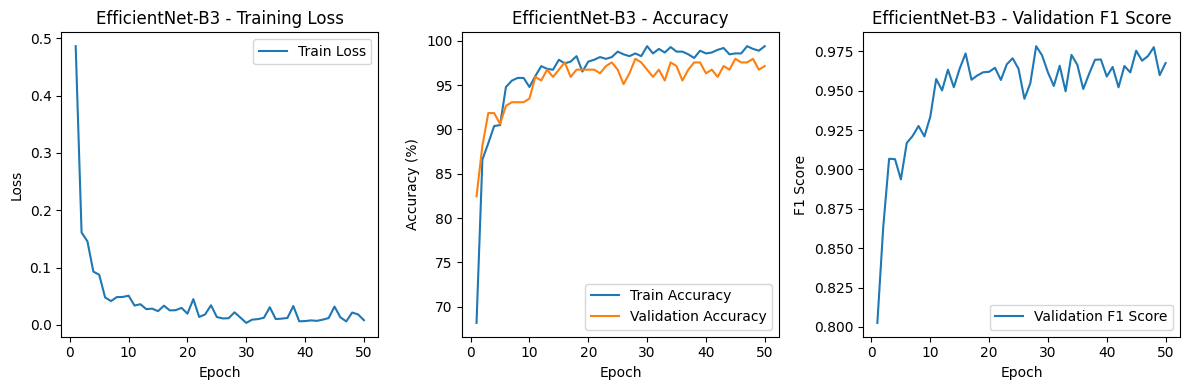

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training ResNet-50...
ResNet-50 - Total Parameters: 23,516,228, Trainable Parameters: 14,972,932


Epoch 1/50: 100%|██████████| 62/62 [00:07<00:00,  8.31it/s, accuracy=85.1, loss=0.771] 



Epoch 1:
Training Loss: 0.1096, Training Accuracy: 85.06%
Validation Accuracy: 93.47%, Validation F1 Score: 0.9304
Time: 0m 9s
Model saved with F1: 0.9304


Epoch 2/50: 100%|██████████| 62/62 [00:07<00:00,  8.38it/s, accuracy=94.8, loss=0.502]  



Epoch 2:
Training Loss: 0.0393, Training Accuracy: 94.78%
Validation Accuracy: 96.33%, Validation F1 Score: 0.9623
Time: 0m 9s
Model saved with F1: 0.9623


Epoch 3/50: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s, accuracy=96.4, loss=0.813]  



Epoch 3:
Training Loss: 0.0316, Training Accuracy: 96.42%
Validation Accuracy: 95.10%, Validation F1 Score: 0.9514
Time: 0m 8s


Epoch 4/50: 100%|██████████| 62/62 [00:07<00:00,  8.41it/s, accuracy=95.1, loss=0.437]   



Epoch 4:
Training Loss: 0.0314, Training Accuracy: 95.09%
Validation Accuracy: 93.06%, Validation F1 Score: 0.9288
Time: 0m 9s


Epoch 5/50: 100%|██████████| 62/62 [00:07<00:00,  8.56it/s, accuracy=96.5, loss=0.164]   



Epoch 5:
Training Loss: 0.0218, Training Accuracy: 96.52%
Validation Accuracy: 96.33%, Validation F1 Score: 0.9618
Time: 0m 8s


Epoch 6/50: 100%|██████████| 62/62 [00:07<00:00,  8.19it/s, accuracy=97.2, loss=0.715]   



Epoch 6:
Training Loss: 0.0252, Training Accuracy: 97.24%
Validation Accuracy: 91.43%, Validation F1 Score: 0.9013
Time: 0m 9s


Epoch 7/50: 100%|██████████| 62/62 [00:07<00:00,  8.54it/s, accuracy=97.6, loss=1.3]     



Epoch 7:
Training Loss: 0.0317, Training Accuracy: 97.65%
Validation Accuracy: 94.69%, Validation F1 Score: 0.9462
Time: 0m 8s


Epoch 8/50: 100%|██████████| 62/62 [00:07<00:00,  8.58it/s, accuracy=97.7, loss=0.315]   



Epoch 8:
Training Loss: 0.0142, Training Accuracy: 97.75%
Validation Accuracy: 95.51%, Validation F1 Score: 0.9555
Time: 0m 8s


Epoch 9/50: 100%|██████████| 62/62 [00:07<00:00,  8.06it/s, accuracy=98.4, loss=0.104]   



Epoch 9:
Training Loss: 0.0095, Training Accuracy: 98.36%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9670
Time: 0m 9s
Model saved with F1: 0.9670


Epoch 10/50: 100%|██████████| 62/62 [00:07<00:00,  8.48it/s, accuracy=98.7, loss=0.565]   



Epoch 10:
Training Loss: 0.0145, Training Accuracy: 98.67%
Validation Accuracy: 96.33%, Validation F1 Score: 0.9628
Time: 0m 9s


Epoch 11/50: 100%|██████████| 62/62 [00:07<00:00,  8.64it/s, accuracy=98.3, loss=0.492]   



Epoch 11:
Training Loss: 0.0160, Training Accuracy: 98.26%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9751
Time: 0m 8s
Model saved with F1: 0.9751


Epoch 12/50: 100%|██████████| 62/62 [00:07<00:00,  8.58it/s, accuracy=98, loss=0.296]     



Epoch 12:
Training Loss: 0.0132, Training Accuracy: 97.95%
Validation Accuracy: 96.73%, Validation F1 Score: 0.9653
Time: 0m 8s


Epoch 13/50: 100%|██████████| 62/62 [00:07<00:00,  8.21it/s, accuracy=98.3, loss=0.317]   



Epoch 13:
Training Loss: 0.0114, Training Accuracy: 98.26%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9838
Time: 0m 9s
Model saved with F1: 0.9838


Epoch 14/50: 100%|██████████| 62/62 [00:07<00:00,  8.48it/s, accuracy=98.9, loss=0.119]   



Epoch 14:
Training Loss: 0.0060, Training Accuracy: 98.87%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9840
Time: 0m 8s
Model saved with F1: 0.9840


Epoch 15/50: 100%|██████████| 62/62 [00:07<00:00,  8.49it/s, accuracy=98.4, loss=0.479]   



Epoch 15:
Training Loss: 0.0137, Training Accuracy: 98.36%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9875
Time: 0m 9s
Model saved with F1: 0.9875


Epoch 16/50: 100%|██████████| 62/62 [00:07<00:00,  7.95it/s, accuracy=98.3, loss=0.176]   



Epoch 16:
Training Loss: 0.0129, Training Accuracy: 98.26%
Validation Accuracy: 99.59%, Validation F1 Score: 0.9957
Time: 0m 9s
Model saved with F1: 0.9957


Epoch 17/50: 100%|██████████| 62/62 [00:07<00:00,  8.37it/s, accuracy=98.6, loss=1.28]    



Epoch 17:
Training Loss: 0.0258, Training Accuracy: 98.57%
Validation Accuracy: 95.92%, Validation F1 Score: 0.9566
Time: 0m 9s


Epoch 18/50: 100%|██████████| 62/62 [00:07<00:00,  8.52it/s, accuracy=98.7, loss=0.685]   



Epoch 18:
Training Loss: 0.0169, Training Accuracy: 98.67%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9882
Time: 0m 8s


Epoch 19/50: 100%|██████████| 62/62 [00:07<00:00,  8.36it/s, accuracy=98.7, loss=0.316]   



Epoch 19:
Training Loss: 0.0106, Training Accuracy: 98.67%
Validation Accuracy: 97.55%, Validation F1 Score: 0.9757
Time: 0m 9s


Epoch 20/50: 100%|██████████| 62/62 [00:07<00:00,  8.45it/s, accuracy=98.7, loss=0.457]   



Epoch 20:
Training Loss: 0.0121, Training Accuracy: 98.67%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9840
Time: 0m 8s


Epoch 21/50: 100%|██████████| 62/62 [00:06<00:00,  9.07it/s, accuracy=99, loss=0.189]     



Epoch 21:
Training Loss: 0.0067, Training Accuracy: 98.98%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 8s
Model saved with F1: 1.0000


Epoch 22/50: 100%|██████████| 62/62 [00:07<00:00,  8.71it/s, accuracy=99.4, loss=0.498]   



Epoch 22:
Training Loss: 0.0117, Training Accuracy: 99.39%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9881
Time: 0m 8s


Epoch 23/50: 100%|██████████| 62/62 [00:07<00:00,  8.57it/s, accuracy=99.5, loss=0.128]   



Epoch 23:
Training Loss: 0.0043, Training Accuracy: 99.49%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 24/50: 100%|██████████| 62/62 [00:06<00:00,  9.16it/s, accuracy=99.4, loss=0.145]   



Epoch 24:
Training Loss: 0.0044, Training Accuracy: 99.39%
Validation Accuracy: 97.96%, Validation F1 Score: 0.9797
Time: 0m 8s


Epoch 25/50: 100%|██████████| 62/62 [00:07<00:00,  8.71it/s, accuracy=99, loss=0.1]       



Epoch 25:
Training Loss: 0.0044, Training Accuracy: 98.98%
Validation Accuracy: 97.96%, Validation F1 Score: 0.9784
Time: 0m 8s


Epoch 26/50: 100%|██████████| 62/62 [00:07<00:00,  8.84it/s, accuracy=99.6, loss=0.525]   



Epoch 26:
Training Loss: 0.0099, Training Accuracy: 99.59%
Validation Accuracy: 97.14%, Validation F1 Score: 0.9702
Time: 0m 8s


Epoch 27/50: 100%|██████████| 62/62 [00:07<00:00,  8.57it/s, accuracy=99.8, loss=0.449]   



Epoch 27:
Training Loss: 0.0083, Training Accuracy: 99.80%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 28/50: 100%|██████████| 62/62 [00:07<00:00,  8.70it/s, accuracy=99.8, loss=0.113]   



Epoch 28:
Training Loss: 0.0028, Training Accuracy: 99.80%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 29/50: 100%|██████████| 62/62 [00:06<00:00,  9.12it/s, accuracy=99.5, loss=0.0944]  



Epoch 29:
Training Loss: 0.0031, Training Accuracy: 99.49%
Validation Accuracy: 99.18%, Validation F1 Score: 0.9921
Time: 0m 8s


Epoch 30/50: 100%|██████████| 62/62 [00:07<00:00,  8.56it/s, accuracy=99.6, loss=0.399]   



Epoch 30:
Training Loss: 0.0078, Training Accuracy: 99.59%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9838
Time: 0m 8s


Epoch 31/50: 100%|██████████| 62/62 [00:07<00:00,  8.67it/s, accuracy=99.6, loss=1.09]    



Epoch 31:
Training Loss: 0.0188, Training Accuracy: 99.59%
Validation Accuracy: 99.18%, Validation F1 Score: 0.9921
Time: 0m 8s


Epoch 32/50: 100%|██████████| 62/62 [00:06<00:00,  8.98it/s, accuracy=99.5, loss=0.792]   



Epoch 32:
Training Loss: 0.0142, Training Accuracy: 99.49%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9838
Time: 0m 8s


Epoch 33/50: 100%|██████████| 62/62 [00:07<00:00,  8.76it/s, accuracy=99.5, loss=0.38]    



Epoch 33:
Training Loss: 0.0075, Training Accuracy: 99.49%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 34/50: 100%|██████████| 62/62 [00:07<00:00,  8.70it/s, accuracy=99.8, loss=0.489]   



Epoch 34:
Training Loss: 0.0084, Training Accuracy: 99.80%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 35/50: 100%|██████████| 62/62 [00:06<00:00,  8.91it/s, accuracy=99.6, loss=1.09]    



Epoch 35:
Training Loss: 0.0189, Training Accuracy: 99.59%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9838
Time: 0m 8s


Epoch 36/50: 100%|██████████| 62/62 [00:06<00:00,  9.01it/s, accuracy=99.8, loss=0.833]   



Epoch 36:
Training Loss: 0.0142, Training Accuracy: 99.80%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 37/50: 100%|██████████| 62/62 [00:06<00:00,  9.00it/s, accuracy=99.5, loss=0.461]   



Epoch 37:
Training Loss: 0.0110, Training Accuracy: 99.49%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 38/50: 100%|██████████| 62/62 [00:07<00:00,  8.28it/s, accuracy=99.6, loss=0.321]   



Epoch 38:
Training Loss: 0.0064, Training Accuracy: 99.59%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 9s


Epoch 39/50: 100%|██████████| 62/62 [00:07<00:00,  8.69it/s, accuracy=99.7, loss=0.738]   



Epoch 39:
Training Loss: 0.0131, Training Accuracy: 99.69%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9838
Time: 0m 8s


Epoch 40/50: 100%|██████████| 62/62 [00:07<00:00,  8.66it/s, accuracy=99.5, loss=0.812]   



Epoch 40:
Training Loss: 0.0151, Training Accuracy: 99.49%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 41/50: 100%|██████████| 62/62 [00:07<00:00,  8.71it/s, accuracy=99.7, loss=0.516]   



Epoch 41:
Training Loss: 0.0096, Training Accuracy: 99.69%
Validation Accuracy: 97.96%, Validation F1 Score: 0.9789
Time: 0m 8s


Epoch 42/50: 100%|██████████| 62/62 [00:07<00:00,  8.44it/s, accuracy=99.7, loss=0.318]   



Epoch 42:
Training Loss: 0.0061, Training Accuracy: 99.69%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 43/50: 100%|██████████| 62/62 [00:06<00:00,  8.87it/s, accuracy=99.6, loss=0.15]    



Epoch 43:
Training Loss: 0.0072, Training Accuracy: 99.59%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 44/50: 100%|██████████| 62/62 [00:07<00:00,  8.58it/s, accuracy=99.6, loss=0.485]   



Epoch 44:
Training Loss: 0.0098, Training Accuracy: 99.59%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 45/50: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s, accuracy=99.9, loss=0.148]   



Epoch 45:
Training Loss: 0.0036, Training Accuracy: 99.90%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 9s


Epoch 46/50: 100%|██████████| 62/62 [00:07<00:00,  8.72it/s, accuracy=99.9, loss=0.785]  



Epoch 46:
Training Loss: 0.0133, Training Accuracy: 99.90%
Validation Accuracy: 98.37%, Validation F1 Score: 0.9838
Time: 0m 8s


Epoch 47/50: 100%|██████████| 62/62 [00:07<00:00,  8.54it/s, accuracy=99.8, loss=0.771]   



Epoch 47:
Training Loss: 0.0137, Training Accuracy: 99.80%
Validation Accuracy: 99.18%, Validation F1 Score: 0.9921
Time: 0m 8s


Epoch 48/50: 100%|██████████| 62/62 [00:07<00:00,  8.65it/s, accuracy=99.5, loss=0.404]   



Epoch 48:
Training Loss: 0.0079, Training Accuracy: 99.49%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 49/50: 100%|██████████| 62/62 [00:07<00:00,  8.49it/s, accuracy=99.8, loss=0.156]   



Epoch 49:
Training Loss: 0.0037, Training Accuracy: 99.80%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


Epoch 50/50: 100%|██████████| 62/62 [00:06<00:00,  9.19it/s, accuracy=99.7, loss=0.493]   



Epoch 50:
Training Loss: 0.0088, Training Accuracy: 99.69%
Validation Accuracy: 98.78%, Validation F1 Score: 0.9878
Time: 0m 8s


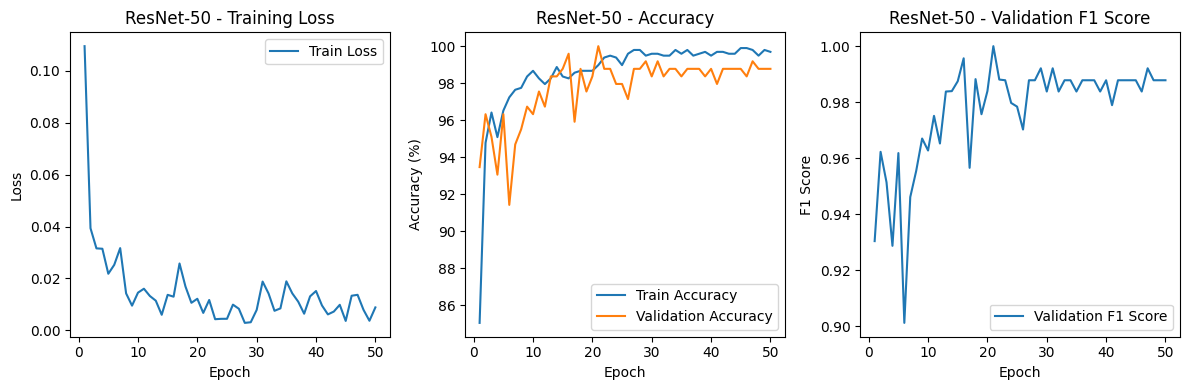

In [32]:
# Fine-tune and train each model
results = {}
num_epochs = 50
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")
    fine_tune_model(model, model_name)
    model = model.to(device)
    criterion = FocalLoss(alpha=0.5, gamma=2.0)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    save_path = f"/kaggle/working/{model_name.lower().replace('-', '_')}_best_model.pth"
    
    best_f1, val_acc, train_loss_list, train_acc_list, val_acc_list, val_f1_list = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path
    )
    results[model_name] = {
        "best_f1": best_f1,
        "val_acc": val_acc,
        "train_loss_list": train_loss_list,
        "train_acc_list": train_acc_list,
        "val_acc_list": val_acc_list,
        "val_f1_list": val_f1_list
    }
    plot_metrics(model_name, train_loss_list, train_acc_list, val_acc_list, val_f1_list)
    models_dict[model_name] = model

In [33]:
 models_dict[model_name] = model

## 7. Evaluation
### 7.1. Ensemble Prediction

In [34]:
# Function for ensemble prediction on validation set
def ensemble_predict(models, loader, device):
    for model in models:
        model.eval()
    all_preds = []
    all_labels = []
    all_ids = []
    with torch.no_grad():
        for images, labels, ids in loader:
            images = images.to(device)
            avg_outputs = torch.zeros((images.size(0), len(classes)), device=device)
            for model in models:
                outputs = model(images)
                avg_outputs += outputs / len(models)
            _, preds = torch.max(avg_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_ids.extend(ids)
    val_acc = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    return val_acc, val_f1, all_preds, all_labels, all_ids

In [35]:
# Function for ensemble prediction on test set
def ensemble_predict_test(models, loader, device):
    for model in models:
        model.eval()
    all_preds = []
    all_ids = []
    with torch.no_grad():
        for images, ids in loader:
            images = images.to(device)
            avg_outputs = torch.zeros((images.size(0), len(classes)), device=device)
            for model in models:
                outputs = model(images)
                avg_outputs += outputs / len(models)
            _, preds = torch.max(avg_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_ids.extend(ids)
    return all_preds, all_ids

### 7.2. Evaluating Ensemble

In [36]:
# Evaluate ensemble
ensemble_models = list(models_dict.values())
ensemble_acc, ensemble_f1, val_preds, val_labels, val_ids = ensemble_predict(ensemble_models, val_loader, device)
results["Ensemble"] = {"best_f1": ensemble_f1, "val_acc": ensemble_acc}

## 8. Visualization
### 8.1. Model Comparison

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


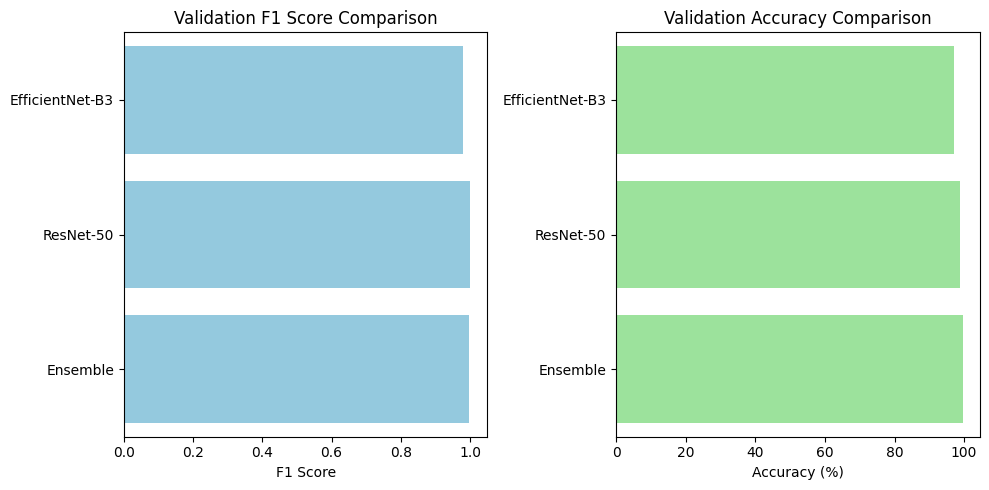


Model Performance Summary:
EfficientNet-B3: F1 Score = 0.9783, Accuracy = 97.14%
ResNet-50: F1 Score = 1.0000, Accuracy = 98.78%
Ensemble: F1 Score = 0.9957, Accuracy = 99.59%


In [37]:
# Visualize comparison of Models
plt.figure(figsize=(10, 5))
model_names = list(results.keys())
f1_scores = [results[name]["best_f1"] for name in model_names]
acc_scores = [results[name]["val_acc"] for name in model_names]

plt.subplot(1, 2, 1)
sns.barplot(x=f1_scores, y=model_names, color='skyblue')
plt.title("Validation F1 Score Comparison")
plt.xlabel("F1 Score")

plt.subplot(1, 2, 2)
sns.barplot(x=acc_scores, y=model_names, color='lightgreen')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.tight_layout()
plt.savefig("/kaggle/working/model_comparison.png")
plt.show()

# Print results
print("\nModel Performance Summary:")
for name in results:
    print(f"{name}: F1 Score = {results[name]['best_f1']:.4f}, Accuracy = {results[name]['val_acc']:.2f}%")

### 8.2. Confusion Matrix

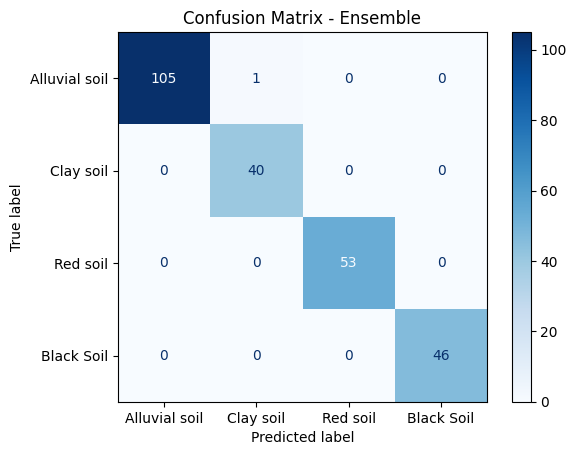

In [38]:
## Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Ensemble")
plt.savefig("/kaggle/working/confusion_matrix.png")
plt.show()

### 8.3. Per-class F1 Scores

In [39]:
## Per-class F1 Scores
per_class_f1 = f1_score(val_labels, val_preds, average=None)
print("\nPer-class F1 Scores:")
for cls, f1 in zip(classes, per_class_f1):
    print(f"{cls}: {f1:.4f}")


Per-class F1 Scores:
Alluvial soil: 0.9953
Clay soil: 0.9877
Red soil: 1.0000
Black Soil: 1.0000


### 8.4. Misclassification Analysis

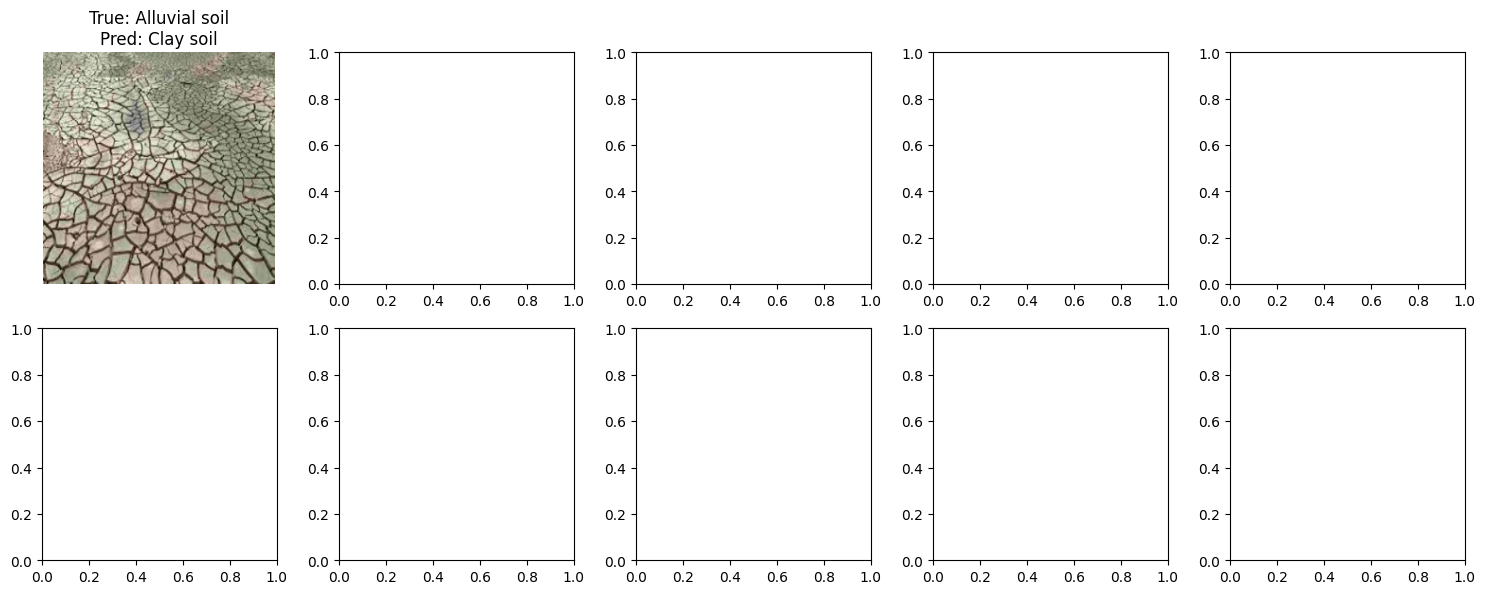

In [40]:
## Misclassification Analysis and Visualization
misclassified_idx = [i for i, (p, l) in enumerate(zip(val_preds, val_labels)) if p != l]
num_to_show = min(10, len(misclassified_idx))
if num_to_show > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, idx in enumerate(misclassified_idx[:num_to_show]):
        image, true_label, img_id = val_dataset[idx]
        image = denormalize_image(image)
        image = image.permute(1, 2, 0).numpy()
        pred_label = val_preds[idx]
        axes[i].imshow(image)
        axes[i].set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig("/kaggle/working/misclassified_samples.png")
    plt.show()
else:
    print("No misclassified samples to visualize.")

### 8.5. Class-wise Misclassification Rates

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


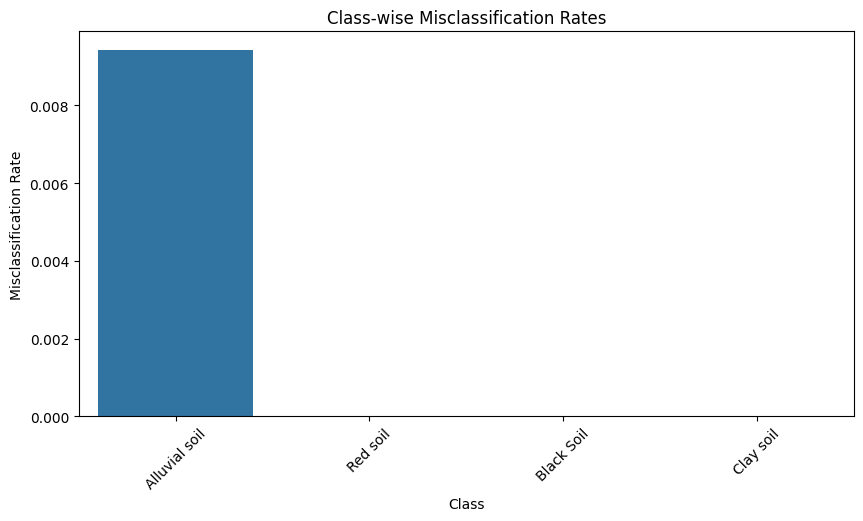

In [42]:
## Class-wise Misclassification Rates
class_counts = Counter(val_labels)
misclassified_counts = Counter()
for p, l in zip(val_preds, val_labels):
    if p != l:
        misclassified_counts[l] += 1
misclassification_rates = {classes[cls]: misclassified_counts.get(cls, 0) / class_counts[cls] for cls in class_counts}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(misclassification_rates.keys()), y=list(misclassification_rates.values()))
plt.title("Class-wise Misclassification Rates")
plt.xlabel("Class")
plt.ylabel("Misclassification Rate")
plt.xticks(rotation=45)
plt.savefig("/kaggle/working/misclassification_rates.png")
plt.show()

## 9. Submission

In [43]:
# Predicted Class Counts on Test Set
test_preds, test_ids = ensemble_predict_test(ensemble_models, test_loader, device)
predicted_counts = Counter(test_preds)
print("\nPredicted Class Counts on Test Set:")
for cls_idx, count in predicted_counts.items():
    print(f"{classes[cls_idx]}: {count}")



Predicted Class Counts on Test Set:
Clay soil: 65
Black Soil: 116
Red soil: 105
Alluvial soil: 55


In [44]:
## Submission File
submission_df = pd.DataFrame({
    "image_id": test_ids,
    "soil_type": [classes[p] for p in test_preds]
})


In [45]:
submission_df.head()

,image_id,soil_type
0,img_0f035b97.jpg,Clay soil
1,img_f13af256.jpg,Clay soil
2,img_15b41dbc.jpg,Black Soil
3,img_cfb4fc7a.jpg,Black Soil
4,img_683111fb.jpg,Black Soil


In [46]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)
print("\nSubmission file saved to /kaggle/working/submission.csv")


Submission file saved to /kaggle/working/submission.csv
